# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.merge import concatenate as concat
from keras.utils.vis_utils import plot_model

# Variational Auto-Encoder(VAE)

## Define and train the VAE model with the MNIST data set.

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Define the VAE as a Model with a custom train_step
class CCVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CCVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder([z, data[1][:,:,0]])
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data[0], reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# we set the dimention of the latent variable as 2 for visualization in this assignment
latent_dim = 2

# load MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255
mnist_digits = np.concatenate([x_train, x_test], axis=0)

y_train_c = keras.utils.to_categorical(y_train)
y_test_c = keras.utils.to_categorical(y_test)
mnist_labels = np.concatenate([y_train_c, y_test_c], axis=0)
mnist_labels = np.expand_dims(mnist_labels, -1)

11501568/11490434 [==============================] - 0s 0us/step


## Build the encoder

In [3]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(80, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 80)           62800       ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 16)           1296        ['dense[0][0]']                  
                                                                                            

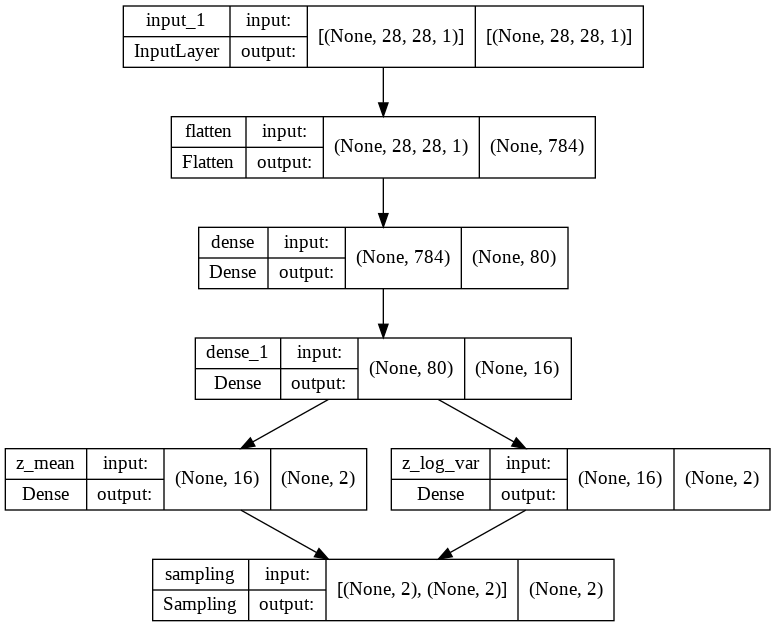

In [4]:
plot_model(encoder, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

## Build the decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(80, activation="relu")(x)
x = layers.Dense(28*28, activation="relu")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 16)                48        
                                                                 
 dense_3 (Dense)             (None, 80)                1360      
                                                                 
 dense_4 (Dense)             (None, 784)               63504     
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 64,912
Trainable params: 64,912
Non-trainable params: 0
_________________________________________________________________


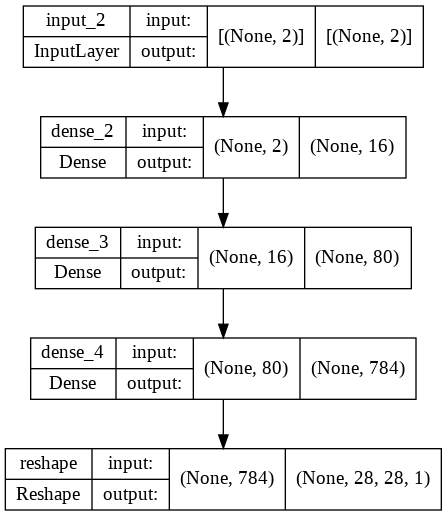

In [6]:
plot_model(decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

## VAE training

In [7]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 11s 8ms/step - loss: 402.1282 - reconstruction_loss: 398.7504 - kl_loss: 3.3778
Epoch 2/30
547/547 [==============================] - 5s 8ms/step - loss: 371.6242 - reconstruction_loss: 368.6297 - kl_loss: 2.9945
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - loss: 349.1287 - reconstruction_loss: 346.1596 - kl_loss: 2.9691
Epoch 4/30
547/547 [==============================] - 3s 5ms/step - loss: 346.6609 - reconstruction_loss: 343.7696 - kl_loss: 2.8913
Epoch 5/30
547/547 [==============================] - 3s 5ms/step - loss: 347.0148 - reconstruction_loss: 344.3591 - kl_loss: 2.6557
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - loss: 344.3918 - reconstruction_loss: 341.5751 - kl_loss: 2.8167
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - loss: 336.1813 - reconstruction_loss: 333.4010 - kl_loss: 2.7803
Epoch 8/30
547/547 [==============================] - 3s 5ms/step - 

## Clusters of different digit classes




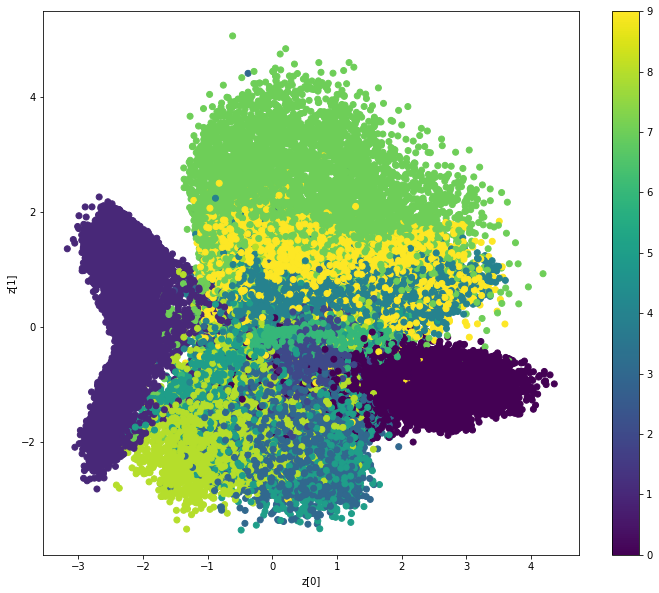

In [8]:
# display a 2D plot of the digit classes in the latent space
def plot_label_clusters(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, x_train, y_train)

## Grid of generated sampled digit images

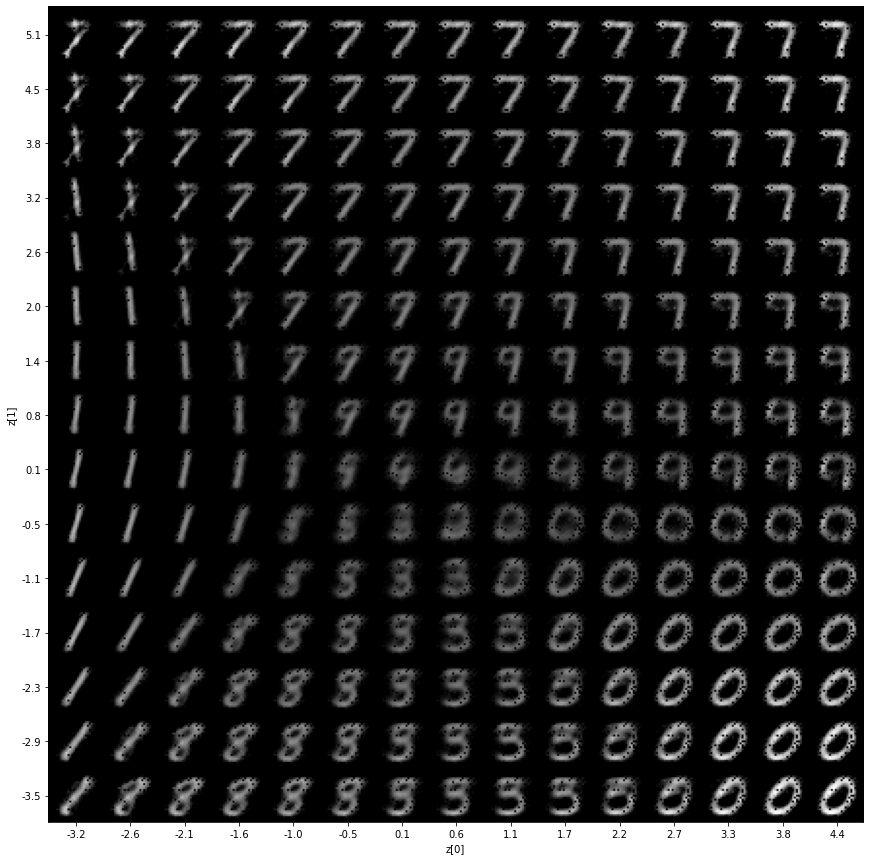

In [9]:
# please find the active regions for latent variables from above 2-D plot and set the fowlling 4 values appropriately
z_mean, _, _ = encoder.predict(x_train)
x_lower = z_mean[:, 0].min()
x_upper = z_mean[:, 0].max()
y_lower = z_mean[:, 1].min()
y_upper = z_mean[:, 1].max()

# Display a grid of sampled digits generated by the VAE model
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 15
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(x_lower, x_upper, n)
    grid_y = np.linspace(y_lower, y_upper, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

## Output of (0,0)

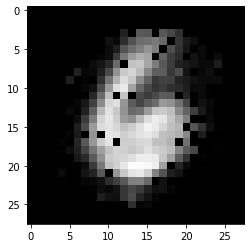

In [10]:
z_sample = np.array([[0, 0]])
x_decoded = decoder.predict(z_sample)
digit = x_decoded[0].reshape(28, 28)

plt.imshow(digit, cmap="Greys_r")
plt.show()

# Convolutional Variational Auto-Encoder(CVAE)

## Build the encoder

In [11]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(14, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="cencoder")
encoder.summary()

Model: "cencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                           

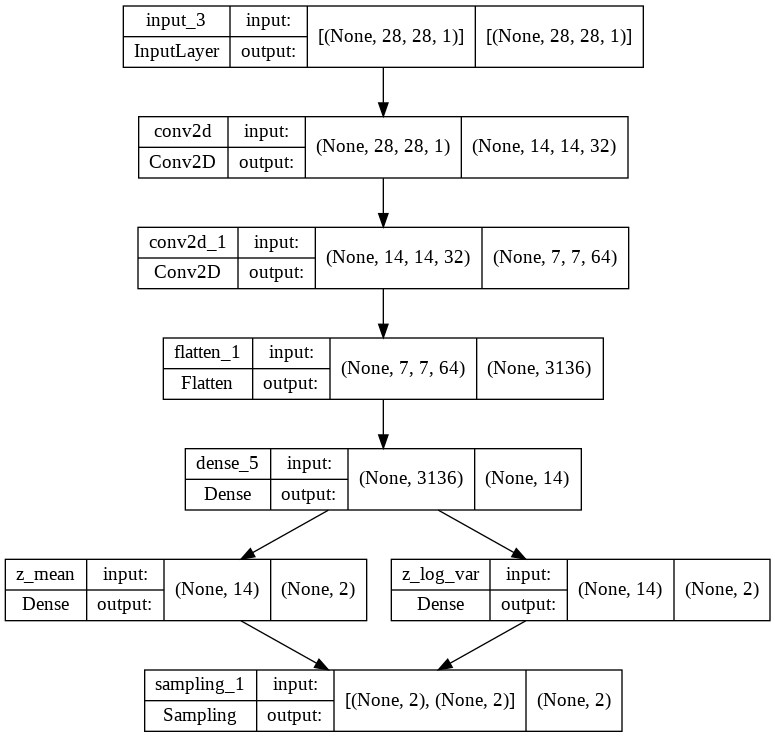

In [12]:
plot_model(encoder, to_file='cencoder_plot.png', show_shapes=True, show_layer_names=True)

## Build the decoder

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="cdecoder")
decoder.summary()

Model: "cdecoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289

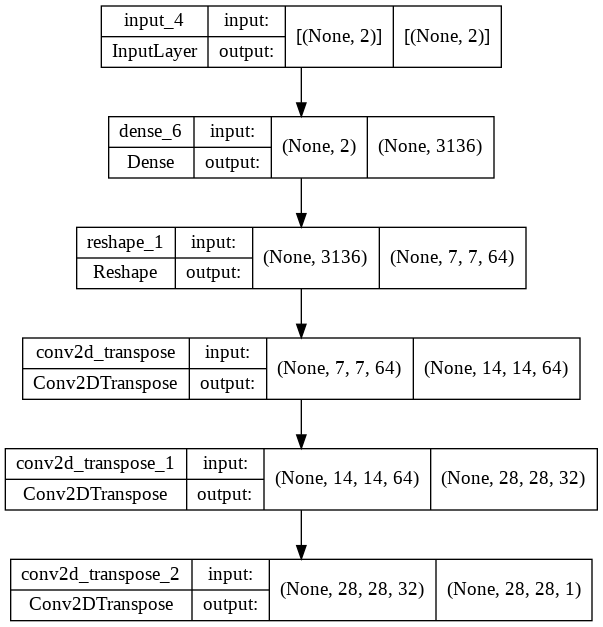

In [14]:
plot_model(decoder, to_file='cdecoder_plot.png', show_shapes=True, show_layer_names=True)

## CVAE training

In [15]:
cvae = VAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 18s 18ms/step - loss: 203.2630 - reconstruction_loss: 201.6825 - kl_loss: 1.5805
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 164.8985 - reconstruction_loss: 162.0691 - kl_loss: 2.8294
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 159.0021 - reconstruction_loss: 155.9149 - kl_loss: 3.0872
Epoch 4/30
547/547 [==============================] - 10s 18ms/step - loss: 156.0301 - reconstruction_loss: 152.8096 - kl_loss: 3.2205
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 154.1765 - reconstruction_loss: 150.8636 - kl_loss: 3.3129
Epoch 6/30
547/547 [==============================] - 10s 18ms/step - loss: 152.8745 - reconstruction_loss: 149.5227 - kl_loss: 3.3518
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 151.9966 - reconstruction_loss: 148.6067 - kl_loss: 3.3899
Epoch 8/30
547/547 [==============================] - 1

## Clusters of different digit classes

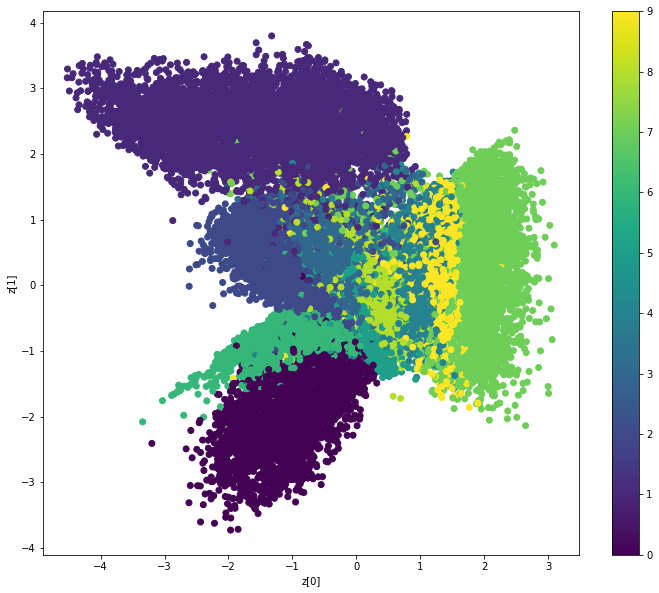

In [16]:
plot_label_clusters(encoder, x_train, y_train)

## Grid of generated sampled digit images

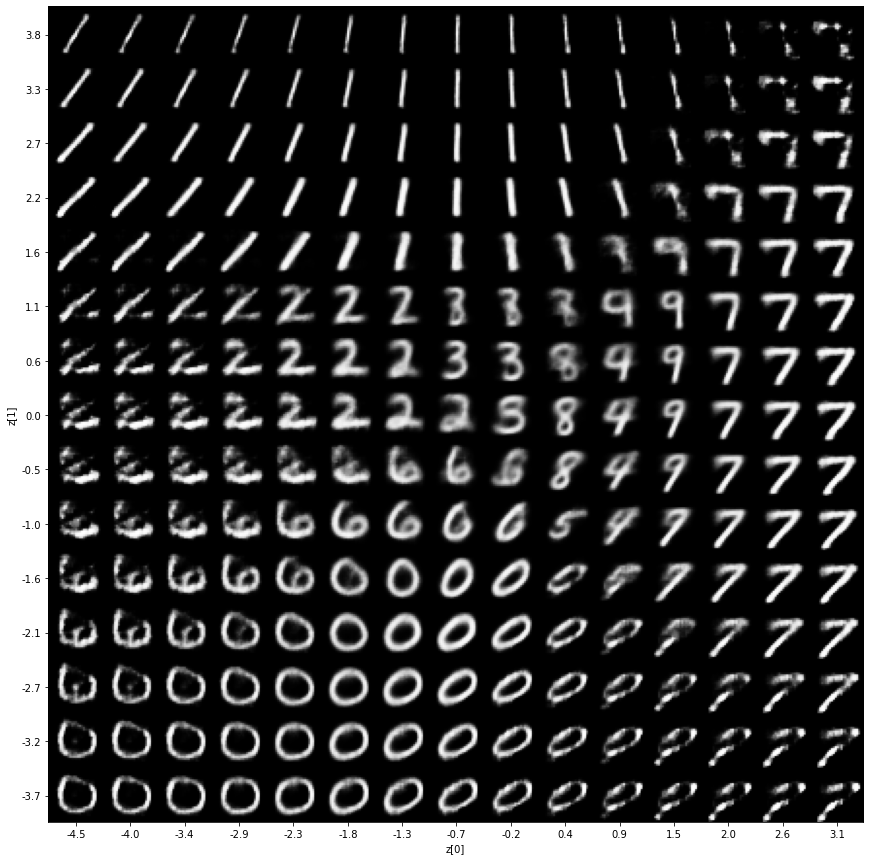

In [17]:
z_mean, _, _ = encoder.predict(x_train)
x_lower = z_mean[:, 0].min()
x_upper = z_mean[:, 0].max()
y_lower = z_mean[:, 1].min()
y_upper = z_mean[:, 1].max()

plot_latent(encoder, decoder)

## Output of (0,0)

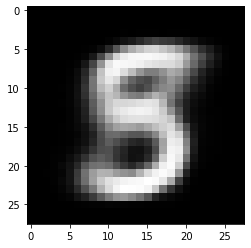

In [18]:
z_sample = np.array([[0, 0]])
x_decoded = decoder.predict(z_sample)
digit = x_decoded[0].reshape(28, 28)

plt.imshow(digit, cmap="Greys_r")
plt.show()

# Conditional Convolutional Variational Auto-Encoder(CCVAE)

In [ ]:
# display a 2D plot of the digit classes in the latent space
def plot_label_clusters(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, x_train, y_train)

## Build the encoder

In [19]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
c = keras.Input(shape=(mnist_labels.shape[1],))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = concat([x, c])
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model([encoder_inputs, c], [z_mean, z_log_var, z], name="ccencoder")
encoder.summary()

Model: "ccencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                          

## Build the decoder

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = concat([latent_inputs, c])
x = layers.Dense(7 * 7 * 64, activation="relu")(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model([latent_inputs, c], decoder_outputs, name="ccdecoder")
decoder.summary()

Model: "ccdecoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 12)           0           ['input_7[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 3136)         40768       ['concatenate_1[0][0]']  

## CCVAE training

In [21]:
ccvae = CCVAE(encoder, decoder)
ccvae.compile(optimizer=keras.optimizers.Adam())
ccvae.fit([mnist_digits, mnist_labels], epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 11s 18ms/step - loss: 175.8985 - reconstruction_loss: 174.4163 - kl_loss: 1.4822
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 135.4219 - reconstruction_loss: 132.7580 - kl_loss: 2.6639
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 132.9944 - reconstruction_loss: 130.3102 - kl_loss: 2.6842
Epoch 4/30
547/547 [==============================] - 10s 18ms/step - loss: 131.9740 - reconstruction_loss: 129.2823 - kl_loss: 2.6917
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 131.2500 - reconstruction_loss: 128.5437 - kl_loss: 2.7063
Epoch 6/30
547/547 [==============================] - 10s 18ms/step - loss: 130.7369 - reconstruction_loss: 128.0202 - kl_loss: 2.7167
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 130.3454 - reconstruction_loss: 127.6388 - kl_loss: 2.7066
Epoch 8/30
547/547 [==============================] - 1

## Clusters of different digit classes

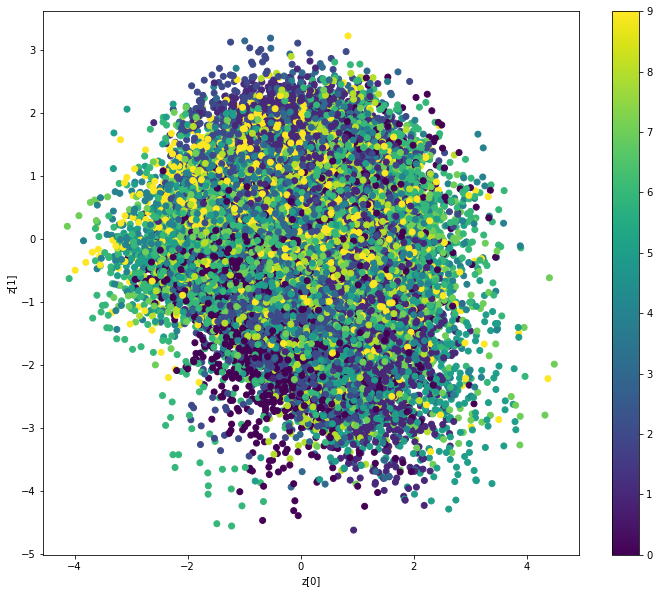

In [23]:
plot_label_clusters(encoder, [x_train, y_train_c], y_train)

## Grid of generated sampled digit images

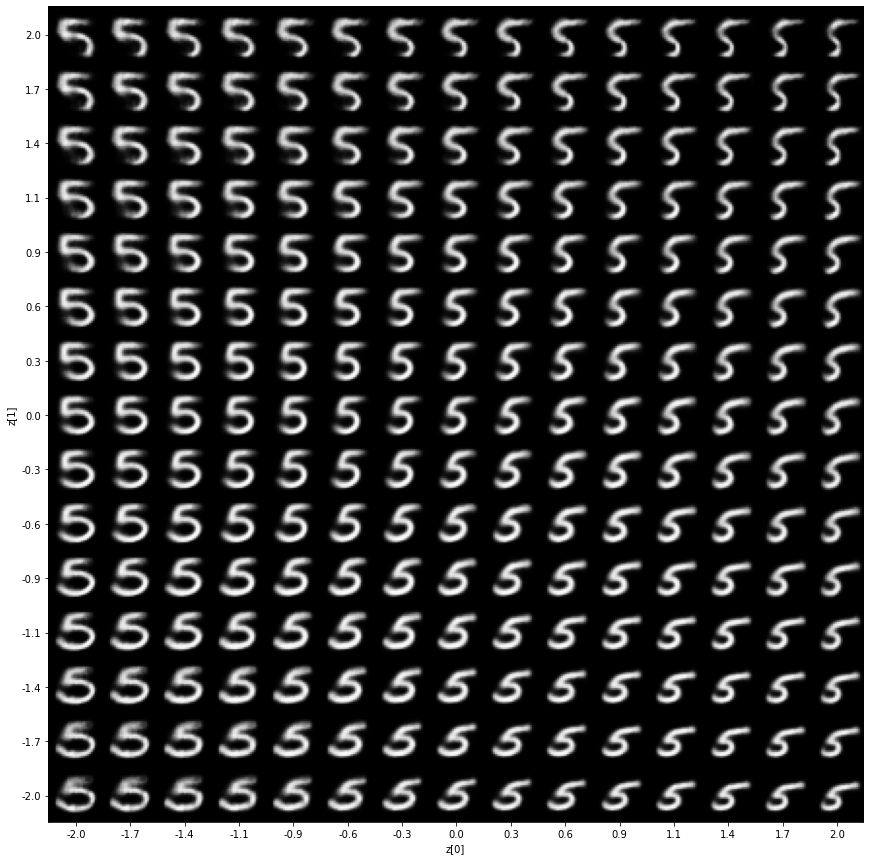

In [64]:
x_lower = -2
x_upper = 2
y_lower = -2
y_upper = 2

# Display a grid of sampled digits generated by the CCVAE model
def plot_latent(encoder, decoder, c):
    # display a n*n 2D manifold of digits
    n = 15
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(x_lower, x_upper, n)
    grid_y = np.linspace(y_lower, y_upper, n)[::-1]
    t = np.zeros(10).reshape(-1,10)
    t[0][c] = 1
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, t])
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 5)

## Output of (0,0)

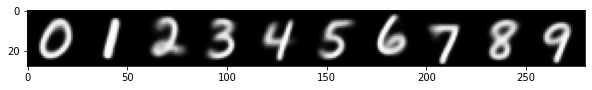

In [67]:
n = 10
digit_size = 28
figsize = 10
figure = np.zeros((digit_size, digit_size * n))

for c in range(10):
    t = np.zeros(10).reshape(-1,10)
    t[0][c] = 1
    z_sample = np.array([[0, 0]])
    x_decoded = decoder.predict([z_sample, t])
    digit = x_decoded[0].reshape(28, 28)
    figure[
            0 : digit_size,
            c * digit_size : (c + 1) * digit_size,
        ] = digit

plt.figure(figsize=(figsize, figsize))
plt.imshow(figure, cmap="Greys_r")
plt.show()